In [ ]:
import snntorch as snn
import sys
import platform
import torch
import pandas as pd
import sklearn as sk
import numpy as np

has_gpu = torch.cuda.is_available()
has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "gpu" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

In [2]:
#Training Parameters 
batch_size = 128 
data_path = "data/mnist"
num_classes = 10  # MNIST has 10 output classes

# Torch Variables
dtype = torch.float

In [ ]:
from torchvision import datasets, transforms

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)

In [4]:
from snntorch import utils

subset = 10
mnist_train = utils.data_subset(mnist_train, subset)

In [5]:
from torch.utils.data import DataLoader

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

# Rate Coding

<img src="https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_2_spikeinput.png?raw=true" width="500" height="300">

- each normalized input feature of MNIST image $X_{ij}$ is used as the probability an event (spike) occurs at any given time step returing a rate-coded value $R_{ij}$ 
- can be treated as a Bernoulli trial (binomial probability distribution): $R_{ij} ~ B(n,p)$, where the # of trials is n = 1 and the probability of success (spiking) is $p = X_{ij}$

<img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*URLjU8geccnWQatuZQzC8Q.png" width="500" height="300">

- *Explicitly, the probability a spike occurs is:*
$$P(R_{ij} = 1) = X_{ij} = 1-P(R_{ij} = 0)$$

In [18]:
# Temporal Dynamics 
num_steps = 10

# create vector filled with 0.5
raw_vector = torch.ones(num_steps)*0.5 # vector of size 10

# pass each sample through a bernoulli trial 
rate_coded_vector = torch.bernoulli(raw_vector) # basically samples binomial distribution for each feature and returns 1 or 0 

print(f"Converted vector: {rate_coded_vector}")
print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

Converted vector: tensor([1., 1., 0., 0., 0., 1., 0., 0., 1., 1.])
The output is spiking 50.00% of the time.


In [39]:
num_steps = 100

# create vector filled with 0.5
raw_vector = torch.ones(num_steps)*0.5

# pass each sample through a Bernoulli trial
rate_coded_vector = torch.bernoulli(raw_vector)
print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")


The output is spiking 38.00% of the time.


As `num_steps` approaches -> $\infty$, the probability of a spike occurring approaches the original raw probabilities in $X$. 

- for MNIST image, proba of spiking corresponds to pixel value
    - white pixel = 100% proba of spiking 
    - black pixel = 0% proba of spiking

<img src="https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_3_spikeconv.png?raw=true" width="600" height="300">

In a similar way, `spikegen.rate` can be used to generate a rate-coded sample of data. As each sample of MNIST is just an image, we can use `num_steps` to repeat it across time.




In [40]:
from snntorch import spikegen

# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data) # returns n samples where n = batch size

print(data_it.shape)
print(targets_it.shape)

# Spiking Data
spike_data = spikegen.rate(data_it, num_steps=num_steps)
print(spike_data.size()) #The structure of the input data is [num_steps x batch_size x input dimensions]

torch.Size([128, 1, 28, 28])
torch.Size([128])
torch.Size([100, 128, 1, 28, 28])


## viz with spikeplot

In [29]:
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt

from IPython.display import HTML

In [41]:
spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())


torch.Size([100, 28, 28])


In [48]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)
plt.rcParams['animation.ffmpeg_path'] = '/Users/anushmutyala/opt/miniconda3/envs/torch/bin/ffmpeg'
plt.close()

HTML(anim.to_html5_video())


In [43]:
print(f"The corresponding target is: {targets_it[0]}")

The corresponding target is: 8


Modulating gain argument to reduce spiking frequency to 25% -> becomes more sparse in time 

In [49]:
spike_data = spikegen.rate(data_it, num_steps=num_steps, gain=0.25)

spike_data_sample2 = spike_data[:, 0, 0]
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample2, fig, ax)

plt.close()
HTML(anim.to_html5_video())

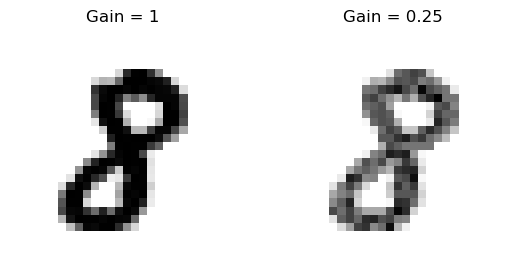

In [50]:
plt.figure(facecolor="w")
plt.subplot(1,2,1)
plt.imshow(spike_data_sample.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 1')

plt.subplot(1,2,2)
plt.imshow(spike_data_sample2.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 0.25')

plt.show()

**raster plot =>  visually examine the trial-by-trial variability of the neural responses** 

The 28*28 spiking array is flattened and each index represents a single neuron -> 784 neurons in total.

reshape sample into 2D tensor with time as 1st dimension and let `spikeplot.raster` handle the rest



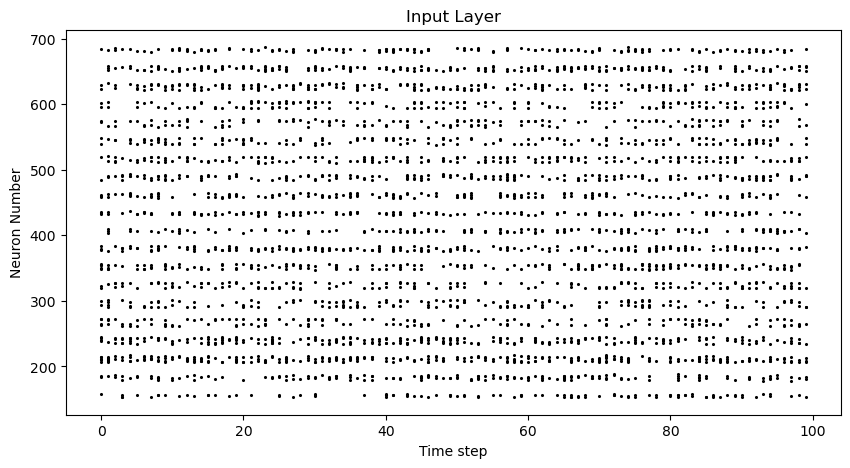

In [51]:
# Reshape
spike_data_sample2 = spike_data_sample2.reshape((num_steps, -1))

# raster plot
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample2, ax, s=1.5, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

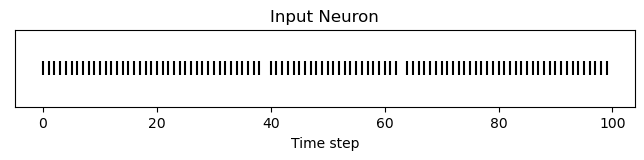

In [54]:
idx = 210  # index into 210th neuron

fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spike_data_sample.reshape(num_steps, -1)[:, idx].unsqueeze(1), ax, s=100, c="black", marker="|")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

## Summary of Rate Coding Notes
The idea of rate coding being the primary spike encoding mechanism is controversial for a few reasons:
1. **power consumption**: rate-coding at most can only explain the activity of 15% of neurons in the primary visual cortex -> unlikely to be the only encoding mechanism within the resource-constrained brain
2. **reaction response times**: reaction time is ~250ms -> if avg firing rate of a neuron is ~10Hz, we can only process about 2 spikes within reaction timescale 

Although the brain may not process data as a rate, our sensory organs do because of the noise robustness vs. power/latency tradeoff -> it’s fine if some of the spikes fail to generate, because there will be plenty more where they came from 

In some cases where training SNNs proves to be challenging, encouraging more firing via a rate code is one possible solution based on Hebbian learning principle. 

# Latency Coding